<a href="https://colab.research.google.com/github/saritmaitra/crypto_prediction/blob/master/BitCoin_trading_strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyforest
from pyforest import *
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import sklearn.metrics
from pylab import rcParams
%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
from google.colab import files

plt.style.use('ggplot')
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
import pandas_datareader as web
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)
!pip install yfinance

In [104]:
import yfinance as yf

btc = yf.Ticker("BTC-USD")
# get historical market data
hist = btc.history(period="max")
df = hist[['Open', 'High', 'Low', 'Close', 'Volume']]
print(df.tail()); print(); print(df.shape)

                    Open          High           Low         Close       Volume
Date                                                                           
2020-12-30  27360.089844  28937.740234  27360.089844  28840.953125  51287442704
2020-12-31  28841.574219  29244.876953  28201.992188  29001.720703  46754964848
2021-01-01  28994.009766  29600.626953  28803.585938  29374.152344  40730301359
2021-01-02  29376.455078  33155.117188  29091.181641  32127.267578  67865420765
2021-01-03  32512.191406  32804.953125  32055.917969  32599.750000  70564462592

(2301, 5)


In [105]:
df = df.sort_index(ascending=True)
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100


In [106]:
df.describe()

,Open,High,Low,Close,Volume
count,2301.000000,2301.000000,2301.000000,2301.000000,2.301000e+03
mean,4955.485377,5082.795371,4828.372949,4969.238903,9.165414e+09
std,4891.694368,5041.204896,4754.439367,4923.809551,1.292546e+10
min,176.897003,211.731003,171.509995,178.102997,5.914570e+06
25%,445.860992,450.661987,440.351013,445.737000,6.299300e+07
50%,3897.081055,3966.174316,3826.513184,3901.131592,3.226250e+09
75%,8419.870117,8653.280273,8204.185547,8441.490234,1.562702e+10
max,32512.191406,33155.117188,32055.917969,32599.750000,7.415677e+10


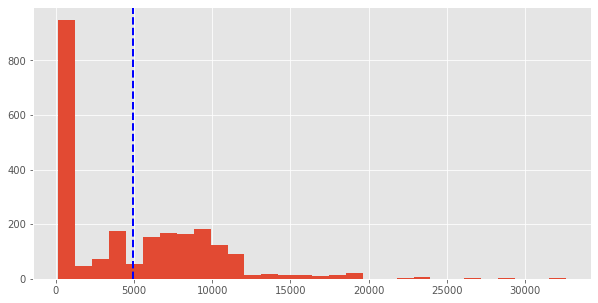

In [107]:
df['Close'].hist(bins=30, figsize=(10,5)).axvline(df['Close'].mean(), 
                                                 color='b', linestyle='dashed', linewidth=2)
plt.show()

In [108]:
fig = go.Figure(data=[go.Candlestick(x=df.index[-30:],
                                     open=df['Open'][-30:],
                                     high=df['High'][-30:],
                                     low=df['Low'][-30:],
                                     close=df['Close'][-30:])])
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_layout(title='Last 30 days BTC price', yaxis_title='BTC (US$)')
fig.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [109]:
btc = df[['Close']]
btc['daily_difference'] = btc['Close'].diff()
btc.head()

,Close,daily_difference
Date,,
2014-09-17,457.334015,NaN
2014-09-18,424.440002,-32.894012
2014-09-19,394.795990,-29.644012
2014-09-20,408.903992,14.108002
2014-09-21,398.821014,-10.082977


In [110]:
btc['signal'] = 0.0
btc['signal'] = np.where(btc['daily_difference'] > 0, 1.0, 0.0)
btc.head()

,Close,daily_difference,signal
Date,,,
2014-09-17,457.334015,NaN,0.0
2014-09-18,424.440002,-32.894012,0.0
2014-09-19,394.795990,-29.644012,0.0
2014-09-20,408.903992,14.108002,1.0
2014-09-21,398.821014,-10.082977,0.0


In [111]:
btc['positions'] = btc['signal'].diff()
btc.head()

,Close,daily_difference,signal,positions
Date,,,,
2014-09-17,457.334015,NaN,0.0,NaN
2014-09-18,424.440002,-32.894012,0.0,0.0
2014-09-19,394.795990,-29.644012,0.0,0.0
2014-09-20,408.903992,14.108002,1.0,1.0
2014-09-21,398.821014,-10.082977,0.0,-1.0


In [146]:
btc.positions.value_counts()

 0.0    1107
 1.0     597
-1.0     596
Name: positions, dtype: int64

For each day where Close price = Buy = red arrow head  and Sell = green arrow head 


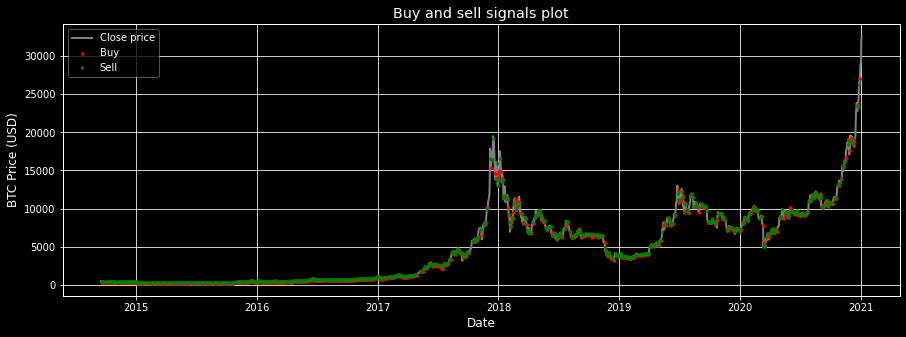

In [145]:
# For each day where open price > 0, we set the signal 1 means sell  and < 0, we set signal 0, to buy 

print('\033[4mFor each day where Close price = Buy = red arrow head  and Sell = green arrow head \033[0m')
buys = btc.loc[btc['positions'] == 1]
sells = btc.loc[btc['positions'] == -1]

# Plot 
fig = plt.figure(figsize=(15, 5))
plt.plot(btc.index, btc['Close'], color = 'gray', lw=2., label='Close price')

# Plot the buy and sell signals on the same plot
plt.plot(buys.index, btc.loc[buys.index]['Close'], '^', markersize=3, color='r',
          label='Buy')
plt.plot(sells.index, btc.loc[sells.index]['Close'], 'v', markersize=3, 
         color='g', label='Sell')
plt.ylabel('BTC Price (USD)')
plt.xlabel('Date')
plt.title('Buy and sell signals plot')
plt.legend(loc=0)

# Display everything
plt.show()

In [113]:
# Initialize the short and long windows
short_window = 10
long_window = 30

# Initialize the `signals` DataFrame with the `signal` column
trade = btc[['Close']]
trade['signal'] = 0.0

# Create short simple moving average over the short window
trade['short_ma'] = btc['Close'].rolling(window=short_window).mean()

# Create long simple moving average over the long window
trade['long_ma'] = btc['Close'].rolling(window=long_window).mean()
# Create signals
trade['signal'][short_window:] = np.where(trade['short_ma'][short_window:] < trade['long_ma'][short_window:], 1.0, 0.0)   

# Generate trading orders
trade['positions'] = trade['signal'].diff()

# Print `signals`
print(trade.tail())

                   Close  signal      short_ma       long_ma  positions
Date                                                                   
2020-12-30  28840.953125     0.0  25422.572852  21749.184310        0.0
2020-12-31  29001.720703     0.0  26042.436719  22089.141732        0.0
2021-01-01  29374.152344     0.0  26601.549023  22428.243750        0.0
2021-01-02  32127.267578     0.0  27490.141211  22850.972721        0.0
2021-01-03  32599.750000     0.0  28376.521289  23314.305534        0.0


In [114]:
#.dropna(inplace=True)
trade.positions.value_counts()

 0.0    2224
-1.0      38
 1.0      38
Name: positions, dtype: int64

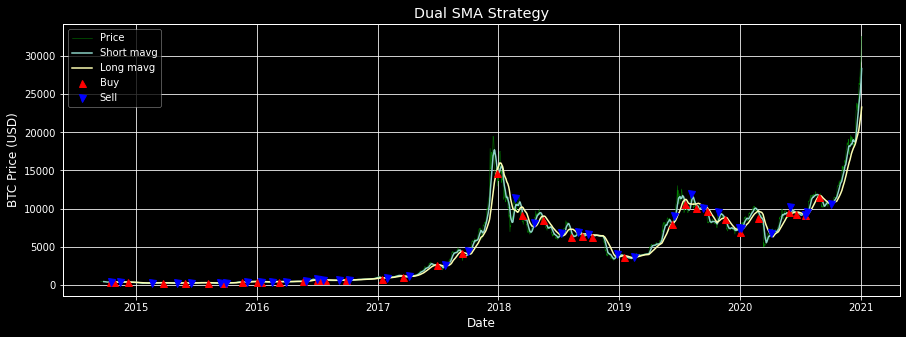

In [142]:
plt.style.use('dark_background')
buys = trade.loc[trade['positions'] == 1]
sells = trade.loc[trade['positions'] == -1]

# Plot 
fig = plt.figure(figsize=(15, 5))
plt.plot(trade.index, trade['Close'], color='g', lw=.5, label='Close price')
# Plot the short and long moving averages
plt.plot(trade[['short_ma', 'long_ma']])
plt.plot(buys.index, trade.loc[buys.index]['Close'],
         '^', markersize=7, color='red', label='Buy')
plt.plot(sells.index, trade.loc[sells.index]['Close'],
         'v', markersize=7, color='blue', label = 'Sell')
plt.ylabel('BTC Price (USD)')
plt.xlabel('Date')
plt.legend(["Price","Short mavg","Long mavg","Buy","Sell"])
plt.title("Dual SMA Strategy")

# Display everything
plt.show()

In [137]:
#print('\033[4mLast 5 Buy signal \033[0m')
#buy = (round(trade.loc[buys.index], 2)['Close'])
#buy = buy.reset_index()
#buy

In [136]:
#print('\033[4mLast 5 Sell signal \033[0m')
#sell = (round(trade.loc[sells.index], 2)['Close'])
#sell = sell.reset_index()
#sell

In [118]:
df.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2020-12-30,27360.089844,28937.740234,27360.089844,28840.953125,51287442704
2020-12-31,28841.574219,29244.876953,28201.992188,29001.720703,46754964848
2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344,40730301359
2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,67865420765
2021-01-03,32512.191406,32804.953125,32055.917969,32599.750000,70564462592


In [119]:
def trading_strategy(df, window_size):
    #newSt = pd.DataFrame(index=df.index)
    newSt = df[['Close']]
    newSt['orders'] = 0
    # window_size-days high
    newSt['High'] = df['Close'].shift(1).rolling(window=window_size).max()
    # window_size-days low
    newSt['Low'] = df['Close'].shift(1).rolling(window=window_size).min()
    # window_size-days mean
    newSt['Avg'] = df['Close'].shift(1).rolling(window=window_size).mean()

    # entry rule : stock price > the higest value for window_size day
    #              stock price < the lowest value for window_size day

    newSt['long_entry'] = df['Close'] > newSt.High
    newSt['short_entry'] = df['Close'] < newSt.Low

    #exit rule : the stock price crosses the mean of past window_size days.

    newSt['long_exit'] = df['Close'] < newSt.Avg
    newSt['short_exit'] = df['Close'] > newSt.Avg

    init=True
    position=0
    for k in range(len(newSt)):
        if newSt['long_entry'][k] and position==0:
            newSt.orders.values[k] = 1
            position=1
        elif newSt['short_entry'][k] and position==0:
            newSt.orders.values[k] = -1
            position=-1
        elif newSt['short_exit'][k] and position>0:
            newSt.orders.values[k] = -1
            position = 0
        elif newSt['long_exit'][k] and position < 0:
            newSt.orders.values[k] = 1
            position = 0
        else:
            newSt.orders.values[k] = 0

    return newSt

In [126]:
#newSt = df[['Close']]
#newSt

In [127]:
#ts

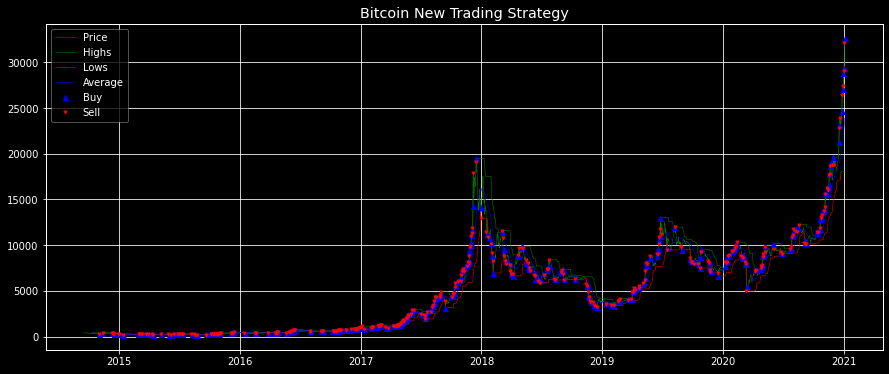

In [143]:
ts=trading_strategy(df, 24)

buys = ts.loc[ts['orders'] == 1]
sells = ts.loc[ts['orders'] == -1]

fig = plt.figure(figsize=(15,6))
plt.plot(df["Close"], color='g', lw=.5)
plt.plot(ts["High"], color='g', lw=.5)
plt.plot(ts["Low"], color='r', lw=.5)
plt.plot(ts["Avg"], color='b', lw=.5)
plt.plot(buys.index, ts.loc[buys.index]['Close'],
         '^', markersize=5, color='blue', label='Buy')
plt.plot(sells.index, ts.loc[sells.index]['Close'],
         'v', markersize = 3, color='r', label = 'Sell')
plt.legend(["Price","Highs","Lows","Average","Buy","Sell"])
plt.title("Bitcoin New Trading Strategy")

plt.show()



In [148]:
ts.orders.value_counts()

 0    1670
 1     316
-1     315
Name: orders, dtype: int64